## Imports

In [1]:
from ast import literal_eval

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

## Load DataFrames

### 1) Processed queries

In [2]:
processed_queries = pd.read_csv(
    "./RESULT/processed_queries.csv",
    sep = ";"
)

### 2) Expected results

In [3]:
raw_expected_results = pd.read_csv(
    "./RESULT/expected_results.csv",
    sep = ";"
)

expected_results = pd.DataFrame(
    columns = [
        "SearchNumber",
        "Results"
    ]
)

for query_number in raw_expected_results["QueryNumber"].unique():
    query_df = raw_expected_results.loc[
        raw_expected_results["QueryNumber"] == query_number
    ].iloc[:, 1:]
    result_tuples = []
    rank = 0
    for doc, score in query_df.sort_values("DocVotes", ascending=False).itertuples(False, None):
        rank += 1
        result_tuples.append((rank, doc, score))
    expected_results = pd.concat([
        expected_results,
        pd.DataFrame(
            [(
                query_number,
                result_tuples
            )],
            columns = [
                "SearchNumber",
                "Results"
            ]
        )
    ])

expected_results = expected_results.reset_index(drop=True)

### 3) Search results (without stemmer)

In [4]:
search_results = pd.read_csv(
    "./RESULT/search_results.csv",
    sep = ";",
    converters = {
        "Results": literal_eval
    }
)

### 4) Search results (with stemmer)

In [5]:
search_results_stemmer = pd.read_csv(
    "./RESULT/search_results_stemmer.csv",
    sep = ";",
    converters = {
        "Results": literal_eval
    }
)

## Helper functions

In [6]:
def get_docs_from_results(results: pd.Series, threshold: float = 0.0) -> list:
    docs = list()
    for result in results:
        score = float(result[2])
        if score > threshold:
            docs.append(int(result[1]))
    return docs


## Analysis

### 0) Stats extraction

In [7]:
stats_dict = dict()

for name, df in [
    ("no_stemmer", search_results),
    ("stemmer", search_results_stemmer)
]:
    # Empty lists
    precisions_list = []
    recalls_list = []
    relevant_recovered_docs_list = []
    recovered_docs_list = []
    relevant_docs_list = []
    p5_list = []
    p10_list = []
    r_precision_list = []

    for query_number in df["SearchNumber"].unique():
        # Recovered docs set
        recovered_docs = set(
            get_docs_from_results(
                df.loc[
                    df["SearchNumber"] == query_number
                ]["Results"].iloc[0],
                threshold = 4
            )
        )

        # Relevant docs set
        relevant_docs = set(
            get_docs_from_results(
                expected_results.loc[
                    expected_results["SearchNumber"] == query_number
                ]["Results"].iloc[0]
            )
        )

        relevant_recovered_docs_list.append(len(recovered_docs.intersection(relevant_docs)))
        recovered_docs_list.append(len(recovered_docs))
        relevant_docs_list.append(len(relevant_docs))

        # List of precisions
        precisions_list.append(
            np.divide(
                len(recovered_docs.intersection(relevant_docs)),
                len(recovered_docs)
            )
        )
        # List of recalls
        recalls_list.append(
            np.divide(
                len(recovered_docs.intersection(relevant_docs)),
                len(relevant_docs)
            )
        )
        # List of P@5s
        p5_list.append(
            np.divide(
                len(
                    set(
                        get_docs_from_results(
                            df.loc[
                                df["SearchNumber"] == query_number
                            ]["Results"].iloc[0][:5],
                            threshold = 4
                        )
                    ).intersection(relevant_docs)
                ),
                5
            )
        )
        # List of P@10s
        p10_list.append(
            np.divide(
                len(
                    set(
                        get_docs_from_results(
                            df.loc[
                                df["SearchNumber"] == query_number
                            ]["Results"].iloc[0][:10],
                            threshold = 4
                        )
                    ).intersection(relevant_docs)
                ),
                10
            )
        )
        # List of R-Precisions
        r_precision_list.append(
            np.divide(
                len(
                    set(
                        get_docs_from_results(
                            df.loc[
                                df["SearchNumber"] == query_number
                            ]["Results"].iloc[0],
                            threshold = 4
                        )[:len(relevant_docs)]
                    ).intersection(relevant_docs)
                ),
                len(relevant_docs)
            )
        )

    precisions_list = np.nan_to_num(precisions_list)
    recalls_list = np.nan_to_num(recalls_list)

    mean_precision = np.mean(precisions_list)
    mean_recall = np.mean(recalls_list)

    stats_dict[name] = {
        "precision": precisions_list,
        "recall": recalls_list,
        "mean_precision": mean_precision,
        "mean_recall": mean_recall,
        "relevant_recovered_docs": relevant_recovered_docs_list,
        "recovered_docs": recovered_docs_list,
        "relevant_docs": relevant_docs_list,
        "p@5": p5_list,
        "p@10": p10_list,
        "r_precision": r_precision_list
    }

C:\Users\pedro\AppData\Local\Temp\ipykernel_28240\244099284.py:40: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


### 1) 11 point precision and recall graph

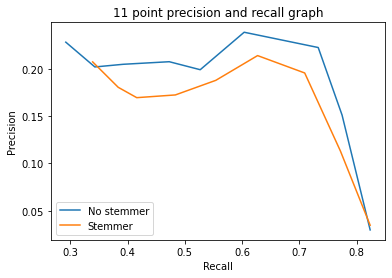

In [8]:
for key in stats_dict.keys():

    eleven_point = pd.DataFrame(
        [i for i in zip(stats_dict[key]["recall"], stats_dict[key]["precision"])],
        columns=["recall", "precision"]
    )

    x = []
    y = []

    for t in range(11):
        threshold = t/10
        split = eleven_point.loc[
            eleven_point["recall"] > threshold
        ]
        x.append(np.mean(split["recall"]))
        y.append(np.mean(split["precision"]))

    plt.plot(x, y, label=key.replace("_"," ").capitalize())

plt.title("11 point precision and recall graph")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend();

### 2) $\mathrm{F_{1}}$

In [9]:
for key in stats_dict.keys():
    print(
        f"F1 ({key}):",
        np.round(
            (
                2*stats_dict[key]["mean_precision"]*stats_dict[key]["mean_recall"]
            )/(
                stats_dict[key]["mean_precision"]+stats_dict[key]["mean_recall"]
            ),
            2
        )
    )

F1 (no_stemmer): 0.24
F1 (stemmer): 0.25


### 3) Precision at 5

In [10]:
for key in stats_dict.keys():
    print(
        f"Precision@5 ({key}):",
        np.round(
            np.mean(stats_dict[key]["p@5"]),
            2
        )
    )

Precision@5 (no_stemmer): 0.41
Precision@5 (stemmer): 0.48


### 4) Precision at 10

In [11]:
for key in stats_dict.keys():
    print(
        f"Precision@10 ({key}):",
        np.round(
            np.mean(stats_dict[key]["p@10"]),
            2
        )
    )

Precision@10 (no_stemmer): 0.35
Precision@10 (stemmer): 0.4


### 5) Comparative R-Precision histogram

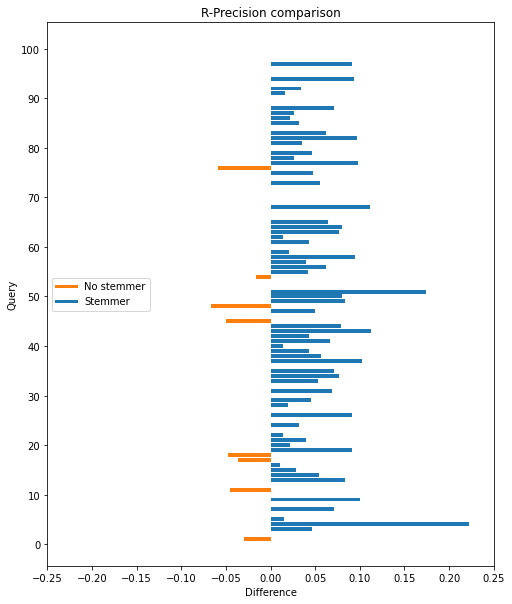

In [12]:
fig, ax = plt.subplots(1, figsize=(8,10))

rp_diff_list = [
    a - b
    for a, b in zip(
        stats_dict["stemmer"]["r_precision"],
        stats_dict["no_stemmer"]["r_precision"]
    )
]

ax.barh(
    df["SearchNumber"].unique(),
    rp_diff_list,
    color=np.where(np.array(rp_diff_list) < 0, 'C1', 'C0')
)

ax.set_title("R-Precision comparison")
ax.set_xlabel("Difference")
ax.set_ylabel("Query")
ax.set_xticks(list(np.arange(-0.25,0.26,0.05)))
ax.set_yticks(list(np.arange(0,101,10)));

legend_elements = [
    Line2D([0], [0], color='C1', lw=3, label='No stemmer'),
    Line2D([0], [0], color='C0', lw=3, label='Stemmer')
]
ax.legend(handles=legend_elements, loc='center left');

### 6) MAP

### 7) MRR

### 8) Mean Discounted Cumulative Gain

### 9) Normalized Discounted Cumulative Gain